In [1]:
import numpy as np
import matplotlib.pyplot as plt
import MulensModel as mm
import scipy.optimize as op
import warnings

warnings.filterwarnings("ignore", category=np.RankWarning)

In [2]:
def chi2_fun(theta, parameters_to_fit, event):

    for (parameter, value) in zip(parameters_to_fit, theta):
        setattr(event.model.parameters, parameter, value)
        
    return event.get_chi2()

def single_fit(mm_data,initial_guess):

    parameters_to_fit = ["t_0", "u_0", "t_E"]
    fit_model = mm.Model({'t_0': initial_guess[0], 'u_0': initial_guess[1], 't_E': initial_guess[2]})
    fit_event = mm.Event(datasets=mm_data, model=fit_model)
    
    result = op.minimize(
    chi2_fun, x0=initial_guess, args=(parameters_to_fit, fit_event),
    method='Nelder-Mead')
    
    (fit_t_0, fit_u_0, fit_t_E) = result.x
    result_list = {'t_0':fit_t_0, 'u_0': fit_u_0, 't_E': fit_t_E}
    return result_list

In [3]:
def single_magnification(t,t0,tE,u0):
    u = np.sqrt(u0**2 + ((t-t0)/tE)**2)
    A = (u**2 + 2)/(u*np.sqrt(u**2 +4))
    
    return A

def calc_A_j_0(t,t0,t_eff):
    Q = 1+((t-t0)/t_eff)**2
    A = 1/np.sqrt(Q)
    
    return A

def calc_A_j_1(t,t0,t_eff):
    Q = 1+((t-t0)/t_eff)**2
    A = (Q+2)/np.sqrt(Q*(Q+4))
    
    return A

def get_flux_1(t0,t_eff,time,flux,ferr):
    A_j_1 = calc_A_j_1(time,t0,t_eff)
    f1, f0 = np.polyfit(A_j_1, flux, 1,w=1/ferr)
    return f1,f0

def get_flux_0(t0,t_eff,time,flux,ferr):
    A_j_0 = calc_A_j_0(time,t0,t_eff)
    f1, f0 = np.polyfit(A_j_0, flux, 1,w=1/ferr)
    return f1,f0
    
    
def get_chi2_A_j_1(t0,t_eff,time,flux,ferr):
    A_j_1 = calc_A_j_1(time,t0,t_eff)
    fs, fb = np.polyfit(A_j_1, flux, 1,w=1/ferr)
    model_flux = A_j_1*fs + fb
    chi2 = np.sum(((flux-model_flux)**2)/ferr)
    
    return chi2

def get_chi2_A_j_0(t0,t_eff,time,flux,ferr):
    A_j_0 = calc_A_j_0(time,t0,t_eff)
    fs, fb = np.polyfit(A_j_0, flux, 1,w=1/ferr)
    model_flux = A_j_0*fs + fb
    chi2 = np.sum(((flux-model_flux)**2)/ferr)
    
    return chi2

def chi2_fun_1(theta,time,flux,ferr):
    return get_chi2_A_j_1(theta[0],theta[1],time,flux,ferr)

def single_fit_A_j_1(time,flux,ferr,t0_init,teff_init):
    
    initial_guess = [t0_init, teff_init]
    
    result = op.minimize(chi2_fun_1, x0=initial_guess,args=(time,flux,ferr),method='Nelder-Mead')
    
    (fit_t_0, fit_t_eff) = result.x
    result_list = {'t_0':fit_t_0, 't_eff': fit_t_eff}
    return fit_t_0, fit_t_eff

def chi2_fun_0(theta,time,flux,ferr):
    return get_chi2_A_j_0(theta[0],theta[1],time,flux,ferr)

def single_fit_A_j_0(time,flux,ferr,t0_init,teff_init):
    
    initial_guess = [t0_init, teff_init]
    
    result = op.minimize(chi2_fun_0, x0=initial_guess,args=(time,flux,ferr),method='Nelder-Mead')
    
    (fit_t_0, fit_t_eff) = result.x
    result_list = {'t_0':fit_t_0, 't_eff': fit_t_eff}
    return fit_t_0, fit_t_eff

Aj0+Aj1を使ったfitting

In [4]:
def calc_A_comb(time,t0,t_eff):
    A_j_0 = calc_A_j_0(time,t0,t_eff)
    A_j_1 = calc_A_j_1(time,t0,t_eff)
    A = A_j_0 + A_j_1
    
    return A
    

def get_chi2_comb(t0,t_eff,time,flux,ferr):
    A_comb = calc_A_comb(time,t0,t_eff)
    fs, fb = np.polyfit(A_comb, flux, 1,w=1/ferr)
    model_flux = A_comb*fs + fb
    chi2 = np.sum(((flux-model_flux)**2)/ferr)
    
    return chi2

def get_flux_comb(t0,t_eff,time,flux,ferr):
    A_j_0 = calc_A_j_0(time,t0,t_eff)
    A_j_1 = calc_A_j_1(time,t0,t_eff)
    A_comb = calc_A_comb(time,t0,t_eff)
    f1, f0 = np.polyfit(A_comb, flux, 1,w=1/ferr)
    return f1,f0

def chi2_fun_comb(theta,time,flux,ferr):
    return get_chi2_comb(theta[0],theta[1],time,flux,ferr)

def single_fit_comb(time,flux,ferr,t0_init,teff_init):
    
    initial_guess = [t0_init, teff_init]
    
    result = op.minimize(chi2_fun_comb, x0=initial_guess,args=(time,flux,ferr),method='Nelder-Mead')
    
    (fit_t_0, fit_t_eff) = result.x
    result_list = {'t_0':fit_t_0, 't_eff': fit_t_eff}
    return fit_t_0, fit_t_eff

In [5]:
moa_raw_data = np.genfromtxt("../gb5-R-8-5-271660.phot.cor",usecols=[0,1,2],names=["time","flux","ferr"])
ind = np.argmin(moa_raw_data["flux"])
moa_raw_data["flux"] = moa_raw_data["flux"]+np.abs(moa_raw_data["flux"][ind])+moa_raw_data["ferr"][ind]+1
moa_raw_data = moa_raw_data[np.where(moa_raw_data["time"]<5000)]

moa_raw_data["time"] += 2450000

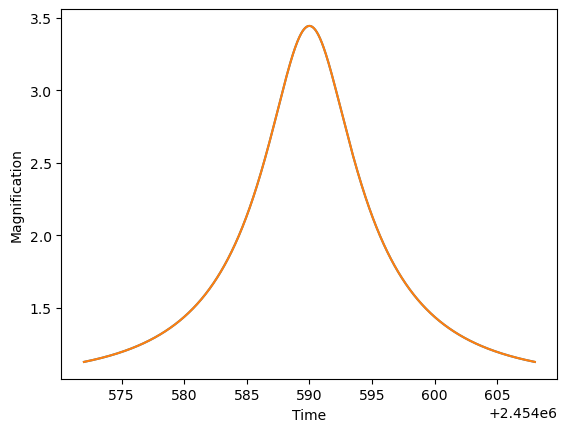

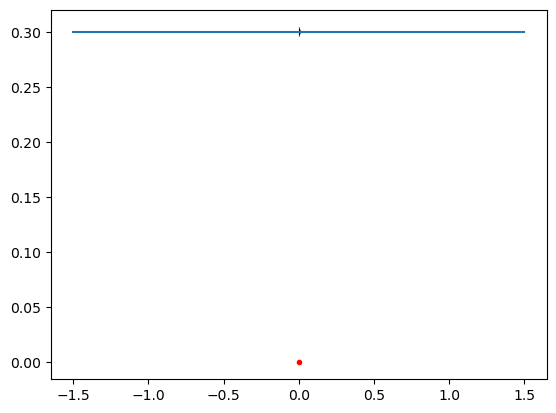

[2454530, 2454650]


In [6]:
t0_in = 2450000+4590
u0_in=0.3
tE_in=12
rho_in=0.01
q_in = 0.01
s_in=1.5
alpha_in = 339.0
fs_in = 10000

coeff=5
t_range = [t0_in-coeff*tE_in,t0_in+coeff*tE_in]

# model_in = mm.Model({'t_0': t0_in, 'u_0': u0_in, 't_E': tE_in,'rho': rho_in,'s':s_in,'q':q_in,'alpha':alpha_in})
model_in = mm.Model({'t_0': t0_in, 'u_0': u0_in, 't_E': tE_in})
# model_in.set_magnification_methods([t_range[0], 'VBBL', t_range[1]])
# model_in.set_default_magnification_method("point_source_point_lens")

model_test = mm.Model({'t_0': t0_in, 'u_0': u0_in, 't_E': tE_in})

model_in.plot_magnification()
model_test.plot_magnification()
plt.show()
model_in.plot_trajectory(caustics=True)
plt.show()

print(t_range)

In [7]:
model_magnification = model_in.get_magnification(moa_raw_data["time"])
in_data_flux = fs_in*(model_magnification-1)+moa_raw_data["flux"]
in_data = mm.MulensData([moa_raw_data["time"],in_data_flux,moa_raw_data["ferr"]],phot_fmt="flux")
in_event = mm.Event(model=model_in,datasets=in_data)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


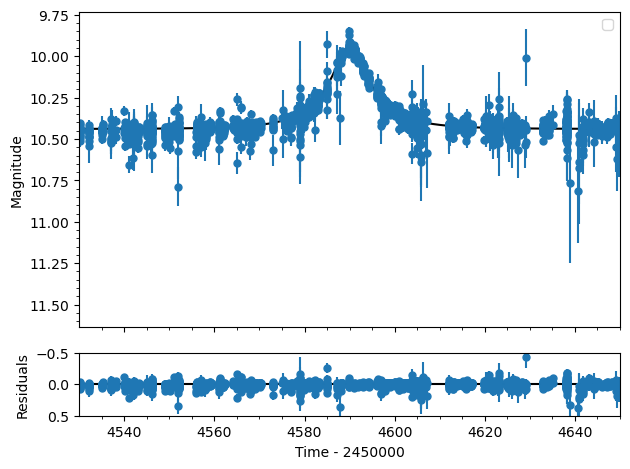

In [8]:
in_event.plot(t_range=[t_range[0],t_range[1]],trajectory=False)
# plt.xlim(t_range[0],t_range[1])
plt.show()

In [9]:
init_params = [t0_in, u0_in, tE_in]

single_result = single_fit(mm_data=in_data,initial_guess=init_params)
single_model = mm.Model(single_result)
single_event = mm.Event(model=single_model,datasets=in_data)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


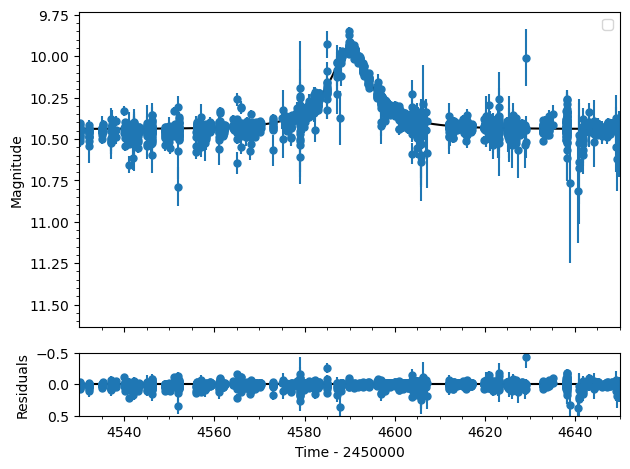

In [10]:
single_event.plot(t_range=[t_range[0],t_range[1]],trajectory=False)
plt.show()

In [11]:
single_model_mag = single_model.get_lc(times=in_data.time,source_flux=
                                            single_event.source_fluxes,blend_flux=single_event.blend_fluxes)
double_model_mag = model_in.get_lc(times=in_data.time,source_flux=
                                            in_event.source_fluxes,blend_flux=in_event.blend_fluxes)

residual_flux = (in_data.flux-mm.Utils.get_flux_from_mag(single_model_mag))[0]

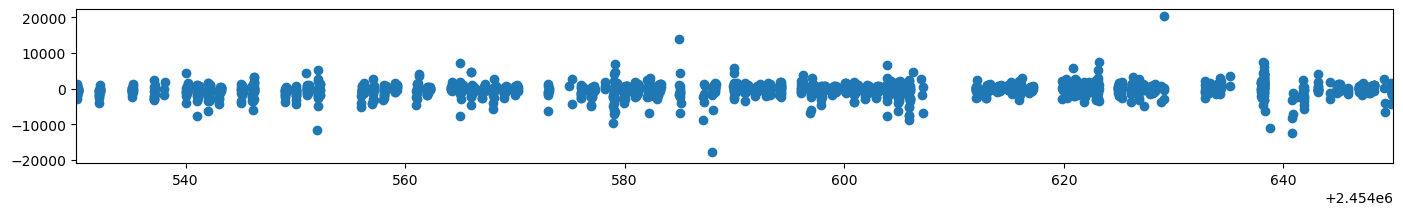

In [12]:
plt.figure(figsize=(17,2))
plt.scatter(in_data.time,residual_flux)

plt.xlim(t_range[0],t_range[1])
plt.show()

残差をt0,teff　フィットする

In [13]:
t_0_init = 2450000+4595
t_eff_init = 0.1

fit_t0_comb, fit_teff_comb = single_fit_comb(in_data.time,residual_flux,in_data.err_flux,t_0_init,t_eff_init)
fit_f1_comb,fit_f0_comb = get_flux_comb(fit_t0_comb,fit_teff_comb,in_data.time,residual_flux,in_data.err_flux)

f_model_comb = fit_f1_comb*calc_A_comb(in_data.time,fit_t0_comb,fit_teff_comb) + fit_f0_comb

print(fit_t0_comb,fit_teff_comb)

2455183.2561248625 0.10064714853570002


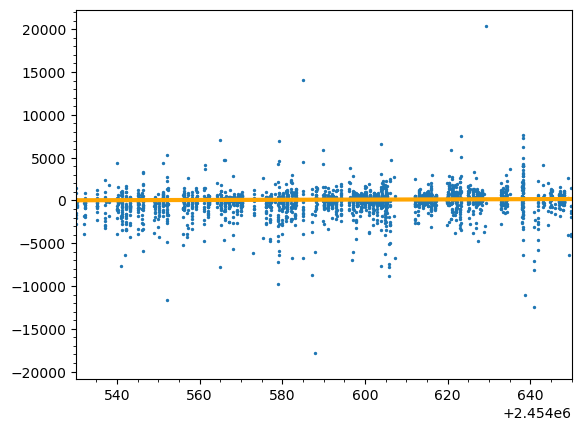

In [14]:
plt.plot(in_data.time,f_model_comb,c="orange",lw=3)
plt.scatter(in_data.time,residual_flux,s=2)
plt.xlim(t_range[0],t_range[1])

plt.minorticks_on()
plt.show()

In [15]:
file_name = "../mock_light_curve.dat"

with open(file_name,"a") as f:
    for i in range(in_data.time.shape[0]):
        f.write(f"{in_data.time[i]}         {in_data.flux[i]}         {in_data.err_flux[i]} \n")

In [16]:
tmp = np.genfromtxt("../gb5-R-8-5-271660.phot.cor",usecols=[0,1,2],names=["time","flux","ferr"])

(4900.0, 5100.0)

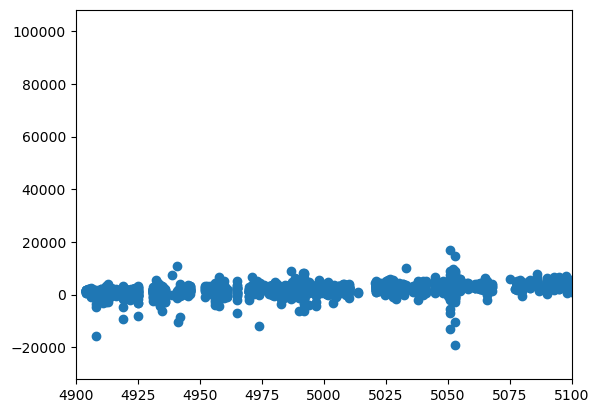

In [17]:
plt.scatter(tmp["time"],tmp["flux"])

plt.xlim(4900,5100)

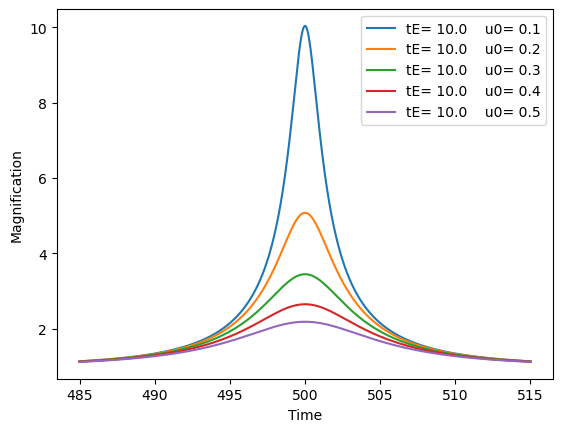

In [18]:
test_model = mm.Model({'t_0': 500, 'u_0': 0.1, 't_E': 10})
test_model.plot_magnification(label=f"tE= {test_model.parameters.t_E}    u0= {test_model.parameters.u_0}")

test_model = mm.Model({'t_0': 500, 'u_0': 0.2, 't_E': 10})
test_model.plot_magnification(label=f"tE= {test_model.parameters.t_E}    u0= {test_model.parameters.u_0}")

test_model = mm.Model({'t_0': 500, 'u_0': 0.3, 't_E': 10})
test_model.plot_magnification(label=f"tE= {test_model.parameters.t_E}    u0= {test_model.parameters.u_0}")

test_model = mm.Model({'t_0': 500, 'u_0': 0.4, 't_E': 10})
test_model.plot_magnification(label=f"tE= {test_model.parameters.t_E}    u0= {test_model.parameters.u_0}")

test_model = mm.Model({'t_0': 500, 'u_0': 0.5, 't_E': 10})
test_model.plot_magnification(label=f"tE= {test_model.parameters.t_E}    u0= {test_model.parameters.u_0}")

plt.legend()
plt.show()

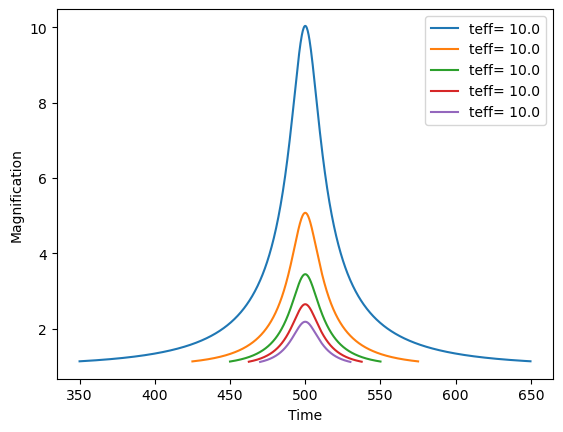

In [19]:
test_model = mm.Model({'t_0': 500, 'u_0': 0.1, 't_E': 10/0.1})
test_model.plot_magnification(label=f"teff= {test_model.parameters.t_E*test_model.parameters.u_0}")

test_model = mm.Model({'t_0': 500, 'u_0': 0.2, 't_E': 10/0.2})
test_model.plot_magnification(label=f"teff= {test_model.parameters.t_E*test_model.parameters.u_0}")

test_model = mm.Model({'t_0': 500, 'u_0': 0.3, 't_E': 10/0.3})
test_model.plot_magnification(label=f"teff= {test_model.parameters.t_E*test_model.parameters.u_0}")

test_model = mm.Model({'t_0': 500, 'u_0': 0.4, 't_E': 10/0.4})
test_model.plot_magnification(label=f"teff= {test_model.parameters.t_E*test_model.parameters.u_0}")

test_model = mm.Model({'t_0': 500, 'u_0': 0.5, 't_E': 10/0.5})
test_model.plot_magnification(label=f"teff= {test_model.parameters.t_E*test_model.parameters.u_0}")

plt.legend()
plt.show()